# Data Preparation
## Group 2

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

In [2]:
# globals
seed = 42

## Data Loading

In [3]:
# instantiate resources json
with open("./resources/student_info_updated.json", "r") as file:
    resources = json.load(file)

# instantiate list of categorical features
categorical = resources['categorical']

# instantiate list of numerical features
numerical = resources['numerical']

# instantiate list of boolean features
booleans = resources['boolean']

# instantiate list of full feature set
features = categorical + booleans + numerical

In [4]:
df = pd.read_csv('./data/our_features_cleaned.csv')
display(df.head())
print(f"Shape of dataset: {df.shape}\n")
print(f"Unique target values: {df['X5GPAALL'].unique()}")

,STU_ID,X1TXMTSCOR,X1PAREDU,X1SES,X1MTHINT,X1SCIINT,X2TXMTSCOR,X2PAREDU,X2BEHAVEIN,X2MTHINT_R,...,S2INSCHSUSP,S2OUTSCHSUSP,S2DISCIPLINE,S2EXPELLED,S2ARRESTED,S2JUVHOME,A1MSMENTOR,A1MSSPEAKER,A1MSFLDTRIP,A1MSPRGMS
0,10001,59.3710,5,1.5644,0.12,-0.23,68.6447,6,-2.17,-0.21,...,1,-7,-7,-7,-7,-7,1,1,1,1
1,10002,47.6821,3,-0.3699,-9.00,-9.00,54.0863,4,0.61,-0.60,...,1,-7,-7,-7,-7,-7,0,0,0,0
2,10003,64.2431,7,1.2741,0.86,0.93,55.6336,7,0.52,-1.39,...,1,-7,-7,-7,-7,-7,1,0,1,1
3,10006,58.1268,3,1.0639,2.08,-7.00,53.9958,5,0.89,-7.00,...,1,-7,-7,-7,-7,-7,0,1,0,0
4,10007,49.4960,2,-0.4300,2.08,0.16,47.6403,2,0.39,-0.47,...,1,-7,-7,-7,-7,-7,0,1,1,1


Shape of dataset: (12588, 41)

Unique target values: [3 1 0 2]


In [5]:
df = df.drop(columns=["STU_ID"])
df.X5GPAALL.value_counts()

X5GPAALL
1    4107
2    3164
3    2899
0    2418
Name: count, dtype: int64

In [6]:
df = df.replace([-1,-2,-3,-4,-5,-6,-7,-8,-9],np.nan)

In [7]:
print(f"Missing values per column: \n{df.isnull().sum()}")

Missing values per column: 
X1TXMTSCOR        971
X1PAREDU         2829
X1SES             971
X1MTHINT         2242
X1SCIINT         3203
X2TXMTSCOR        837
X2PAREDU          724
X2BEHAVEIN       1146
X2MTHINT_R       2612
X2SCIINT         3145
X3TGPAHIMTH       705
X3TGPAHISCI       674
X3TGPAACAD        599
X3TGPASTEM        601
X4X2SES           724
X5GPAALL            0
S1GOODGRADES     1117
S1HRMHOMEWK      2051
S1HRSHOMEWK      2786
S1HROTHHOMWK     1264
S1HRACTIVITY     1290
S1HRTV           1262
S1HRVIDEO        1545
S1HRONLINE       1358
S2LATESCH         921
S2ABSENT          965
S2WOHWDN          951
S2WOPAPER         921
S2WOBOOKS         944
S2SKIPCLASS       943
S2INSCHSUSP       947
S2OUTSCHSUSP    12509
S2DISCIPLINE    12509
S2EXPELLED      12510
S2ARRESTED      12509
S2JUVHOME       12509
A1MSMENTOR       1729
A1MSSPEAKER      1729
A1MSFLDTRIP      1729
A1MSPRGMS        1729
dtype: int64


In [8]:
# "S2OUTSCHSUSP", "S2DISCIPLINE", "S2EXPELLED", "S2ARRESTED", "S2JUVHOME" will be removed due to the large number of missing values
df = df.drop(columns=["S2OUTSCHSUSP", "S2DISCIPLINE", "S2EXPELLED", "S2ARRESTED", "S2JUVHOME"])

In [9]:
X = df.drop(columns=["X5GPAALL"])
y = df.X5GPAALL

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.25, random_state = seed, stratify=y
)

In [11]:
from sklearn.impute import SimpleImputer

cat_cols = categorical + booleans
num_cols = numerical

num_imputer = SimpleImputer(strategy="mean")
cat_imputer = SimpleImputer(strategy="most_frequent")

X_train_num = X_train[num_cols]
X_train_cat = X_train[cat_cols]

#fit and transform training
X_train_num_imp = pd.DataFrame(num_imputer.fit_transform(X_train_num), columns=num_cols, index=X_train.index)
X_train_cat_imp = pd.DataFrame(cat_imputer.fit_transform(X_train_cat), columns=cat_cols, index=X_train.index)

#transform testing
X_test_num_imp = pd.DataFrame(num_imputer.transform(X_test[num_cols]), columns=num_cols, index=X_test.index)
X_test_cat_imp = pd.DataFrame(cat_imputer.transform(X_test[cat_cols]), columns=cat_cols, index=X_test.index)

In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scale = pd.DataFrame(scaler.fit_transform(X_train_num_imp), columns=num_cols, index=X_train.index)
X_test_scale = pd.DataFrame(scaler.transform(X_test_num_imp), columns=num_cols, index=X_test.index)

X_train_final = pd.concat([X_train_scale, X_train_cat_imp], axis=1)
X_test_final = pd.concat([X_test_scale, X_test_cat_imp], axis=1)

In [13]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=seed)

X_train_final, y_train_final = smote.fit_resample(X_train_final, y_train)

print(f"No. of SMOTE instances: {len(y_train_final)}")
print(f"No. of zero instances: {sum(y_train_final==0)}")
print(f"No. of one instances: {sum(y_train_final==1)}")
print(f"No. of two instances: {sum(y_train_final==2)}")

No. of SMOTE instances: 12320
No. of zero instances: 3080
No. of one instances: 3080
No. of two instances: 3080


## Baseline Multi-class Logistic Regression Model

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report

mlr_model = LogisticRegression(max_iter=1000, random_state=seed)
mlr_model.fit(X_train_final, y_train_final)

mlr_y_hat1 = mlr_model.predict(X_test_final)

mlr_precision_1 = precision_score(y_test, mlr_y_hat1, average="macro", zero_division=0)
print("Precision:", mlr_precision_1)
mlr_recall_1 = recall_score(y_test, mlr_y_hat1, average="macro", zero_division=0)
print("Recall:", mlr_recall_1)
mlr_f1_1 = f1_score(y_test, mlr_y_hat1, average="macro", zero_division=0)
print("F1 Score:", mlr_f1_1)
mlr_accuracy_1 = accuracy_score(y_test, mlr_y_hat1)
print("Accuracy:", mlr_accuracy_1)
print(classification_report(y_test, mlr_y_hat1, zero_division=0))

Precision: 0.4168980651869819
Recall: 0.44875318747581644
F1 Score: 0.4194297431862911
Accuracy: 0.42198919605973945
              precision    recall  f1-score   support

           0       0.42      0.60      0.50       604
           1       0.44      0.27      0.33      1027
           2       0.34      0.29      0.31       791
           3       0.47      0.64      0.54       725

    accuracy                           0.42      3147
   macro avg       0.42      0.45      0.42      3147
weighted avg       0.42      0.42      0.41      3147



## Backwards Feature Elimination

In [15]:
import statsmodels.api as sm

def backward_elimination(X, y, sl=0.05, dropped=None):
    if dropped is None:
        dropped = []

    # Fit OLS with an intercept
    X_with_const = sm.add_constant(X)
    X_with_const = X_with_const.astype("float64")
    model = sm.MNLogit(y, X_with_const).fit(disp=False)

    # Extract p-values of x values
    pvalues = model.pvalues.iloc[1:]

    # Find the maximum p-value and corresponding feature
    pvalues = model.pvalues.iloc[1:]  # exclude intercept
    max_pvals = pvalues.max(axis=1)   # max p-value per feature

    # Find the feature with the highest p-value
    max_pval = max_pvals.max()
    if max_pval > sl:
        feature_to_drop = max_pvals.idxmax()
        dropped.append(feature_to_drop)

        # Recurse without that feature
        return backward_elimination(
            X.drop(columns=[feature_to_drop]),
            y,
            sl,
            dropped
        )
    else:
        # Stop recursion; all p-values are below threshold
        retained = list(X.columns)
        return retained, dropped, model

In [16]:
retained_1, dropped_1, final_ols_1 = backward_elimination(X_train_final, y_train_final, sl=0.10)

print("Retained features:")
print(retained_1)

print("\nDropped features:")
print(dropped_1)

Retained features:
['X1TXMTSCOR', 'X4X2SES', 'X2TXMTSCOR', 'X2MTHINT_R', 'X2BEHAVEIN', 'X3TGPAHISCI', 'X3TGPASTEM', 'X3TGPAACAD', 'S2WOBOOKS', 'S2SKIPCLASS', 'A1MSSPEAKER', 'A1MSPRGMS']

Dropped features:
['S1GOODGRADES', 'S2LATESCH', 'S1HRACTIVITY', 'X1SES', 'S2WOPAPER', 'S1HRSHOMEWK', 'S2WOHWDN', 'A1MSFLDTRIP', 'S1HRTV', 'S1HRMHOMEWK', 'X1PAREDU', 'X2PAREDU', 'S1HRVIDEO', 'S1HRONLINE', 'A1MSMENTOR', 'X3TGPAHIMTH', 'X2SCIINT', 'X1MTHINT', 'S2INSCHSUSP', 'S2ABSENT', 'X1SCIINT', 'S1HROTHHOMWK']


In [17]:
retained_5, dropped_5, final_ols_5 = backward_elimination(X_train_final, y_train_final, sl=0.05)

print("Retained features:")
print(retained_5)

print("\nDropped features:")
print(dropped_5)

Retained features:
['X4X2SES', 'X2TXMTSCOR', 'X2MTHINT_R', 'X2BEHAVEIN', 'X3TGPASTEM', 'X3TGPAACAD', 'S2WOBOOKS', 'S2SKIPCLASS']

Dropped features:
['S1GOODGRADES', 'S2LATESCH', 'S1HRACTIVITY', 'X1SES', 'S2WOPAPER', 'S1HRSHOMEWK', 'S2WOHWDN', 'A1MSFLDTRIP', 'S1HRTV', 'S1HRMHOMEWK', 'X1PAREDU', 'X2PAREDU', 'S1HRVIDEO', 'S1HRONLINE', 'A1MSMENTOR', 'X3TGPAHIMTH', 'X2SCIINT', 'X1MTHINT', 'S2INSCHSUSP', 'S2ABSENT', 'X1SCIINT', 'S1HROTHHOMWK', 'X3TGPAHISCI', 'A1MSPRGMS', 'X1TXMTSCOR', 'A1MSSPEAKER']


# Multi-class Logistic Regression Model with 0.10 p-value Retained Features

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report

X_train_reduced1 = X_train_final[retained_1]
X_test_reduced1 = X_test_final[retained_1]

mlr_model2 = LogisticRegression(max_iter=1000, random_state=seed)
mlr_model2.fit(X_train_reduced1, y_train_final)

mlr_y_hat2 = mlr_model2.predict(X_test_reduced1)

mlr_precision_2 = precision_score(y_test, mlr_y_hat2, average="macro", zero_division=0)
print("Precision:", mlr_precision_2)
mlr_recall_2 = recall_score(y_test, mlr_y_hat2, average="macro", zero_division=0)
print("Recall:", mlr_recall_2)
mlr_f1_2 = f1_score(y_test, mlr_y_hat2, average="macro", zero_division=0)
print("F1 Score:", mlr_f1_2)
mlr_accuracy_2 = accuracy_score(y_test, mlr_y_hat2)
print("Accuracy:", mlr_accuracy_2)
print(classification_report(y_test, mlr_y_hat2, zero_division=0))

Precision: 0.4112919228872843
Recall: 0.4494513627951667
F1 Score: 0.4126955742992935
Accuracy: 0.41912932952017795
              precision    recall  f1-score   support

           0       0.43      0.63      0.51       604
           1       0.43      0.25      0.32      1027
           2       0.33      0.25      0.28       791
           3       0.45      0.67      0.54       725

    accuracy                           0.42      3147
   macro avg       0.41      0.45      0.41      3147
weighted avg       0.41      0.42      0.40      3147



# Multi-class Logistic Regression Model with 0.05 p-value Retained Features

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report

X_train_reduced5 = X_train_final[retained_5]
X_test_reduced5 = X_test_final[retained_5]

mlr_model3 = LogisticRegression(max_iter=1000, random_state=seed)
mlr_model3.fit(X_train_reduced5, y_train_final)

mlr_y_hat3 = mlr_model3.predict(X_test_reduced5)

mlr_precision_3 = precision_score(y_test, mlr_y_hat3, average="macro", zero_division=0)
print("Precision:", mlr_precision_3)
mlr_recall_3 = recall_score(y_test, mlr_y_hat3, average="macro", zero_division=0)
print("Recall:", mlr_recall_3)
mlr_f1_3 = f1_score(y_test, mlr_y_hat3, average="macro", zero_division=0)
print("F1 Score:", mlr_f1_3)
mlr_accuracy_3 = accuracy_score(y_test, mlr_y_hat3)
print("Accuracy:", mlr_accuracy_3)
print(classification_report(y_test, mlr_y_hat3, zero_division=0))

Precision: 0.4112233614524974
Recall: 0.45065403847578306
F1 Score: 0.41209171650290033
Accuracy: 0.42008261836669847
              precision    recall  f1-score   support

           0       0.43      0.62      0.51       604
           1       0.43      0.25      0.31      1027
           2       0.34      0.24      0.28       791
           3       0.45      0.69      0.55       725

    accuracy                           0.42      3147
   macro avg       0.41      0.45      0.41      3147
weighted avg       0.41      0.42      0.40      3147



In [20]:
metrics1 = {
    "Baseline Model": {
        "Precision": mlr_precision_1,
        "Recall": mlr_recall_1,
        "F1 Score": mlr_f1_1,
        "Accuracy": mlr_accuracy_1
    },
    "Reduced Model 0.10": {
        "Precision": mlr_precision_2,
        "Recall": mlr_recall_2,
        "F1 Score": mlr_f1_2,
        "Accuracy": mlr_accuracy_2
    },
    "Reduced Model 0.05": {
        "Precision": mlr_precision_3,
        "Recall": mlr_recall_3,
        "F1 Score": mlr_f1_3,
        "Accuracy": mlr_accuracy_3
    }
}

metric1_df = pd.DataFrame(metrics1)

display(metric1_df)

,Baseline Model,Reduced Model 0.10,Reduced Model 0.05
Precision,0.416898,0.411292,0.411223
Recall,0.448753,0.449451,0.450654
F1 Score,0.419430,0.412696,0.412092
Accuracy,0.421989,0.419129,0.420083


## Dimensionality Reduction

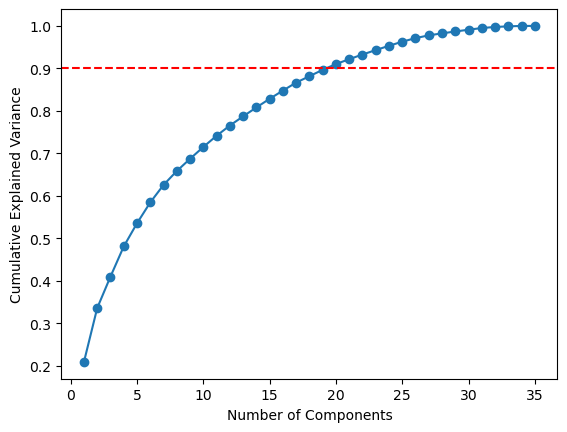

In [21]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA().fit(X_train_final)

# Plot cumulative explained variance
plt.plot(range(1, len(pca.explained_variance_ratio_)+1),
         pca.explained_variance_ratio_.cumsum(), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(y=0.90, color='r', linestyle='--')  # target threshold
plt.show()

In [22]:
from sklearn.decomposition import PCA

pca18 = PCA(n_components = 18)
X_train_pca18 = pca18.fit_transform(X_train_final)
X_test_pca18 = pca18.transform(X_test_final)

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report

mlr_model_pca = LogisticRegression(max_iter=1000, random_state=seed)
mlr_model_pca.fit(X_train_pca18, y_train_final)

mlr_y_hat4 = mlr_model_pca.predict(X_test_pca18)

mlr_precision_4 = precision_score(y_test, mlr_y_hat4, average="macro", zero_division=0)
print("Precision:", mlr_precision_4)
mlr_recall_4 = recall_score(y_test, mlr_y_hat4, average="macro", zero_division=0)
print("Recall:", mlr_recall_4)
mlr_f1_4 = f1_score(y_test, mlr_y_hat4, average="macro", zero_division=0)
print("F1 Score:", mlr_f1_4)
mlr_accuracy_4 = accuracy_score(y_test, mlr_y_hat4)
print("Accuracy:", mlr_accuracy_4)
print(classification_report(y_test, mlr_y_hat4, zero_division=0))

Precision: 0.41519993074396694
Recall: 0.45172955114367175
F1 Score: 0.41754405211715945
Accuracy: 0.42198919605973945
              precision    recall  f1-score   support

           0       0.43      0.64      0.51       604
           1       0.44      0.26      0.33      1027
           2       0.33      0.26      0.29       791
           3       0.47      0.64      0.54       725

    accuracy                           0.42      3147
   macro avg       0.42      0.45      0.42      3147
weighted avg       0.42      0.42      0.40      3147



In [24]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()

X_train_lda = lda.fit_transform(X_train_final, y_train_final)
X_test_lda = lda.transform(X_test_final)

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report

mlr_model_lda = LogisticRegression(max_iter=1000, random_state=seed)
mlr_model_lda.fit(X_train_lda, y_train_final)

mlr_y_hat5 = mlr_model_lda.predict(X_test_lda)

mlr_precision_5 = precision_score(y_test, mlr_y_hat5, average="macro", zero_division=0)
print("Precision:", mlr_precision_5)
mlr_recall_5 = recall_score(y_test, mlr_y_hat5, average="macro", zero_division=0)
print("Recall:", mlr_recall_5)
mlr_f1_5 = f1_score(y_test, mlr_y_hat5, average="macro", zero_division=0)
print("F1 Score:", mlr_f1_5)
mlr_accuracy_5 = accuracy_score(y_test, mlr_y_hat5)
print("Accuracy:", mlr_accuracy_5)
print(classification_report(y_test, mlr_y_hat5, zero_division=0))

Precision: 0.4202424779416388
Recall: 0.4523740433731166
F1 Score: 0.42348814676414726
Accuracy: 0.42548458849698123
              precision    recall  f1-score   support

           0       0.43      0.61      0.51       604
           1       0.45      0.27      0.34      1027
           2       0.33      0.28      0.30       791
           3       0.47      0.64      0.54       725

    accuracy                           0.43      3147
   macro avg       0.42      0.45      0.42      3147
weighted avg       0.42      0.43      0.41      3147



In [26]:
from sklearn.decomposition import KernelPCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([
    ('kpca', KernelPCA(kernel='rbf')),
    ('clf', LogisticRegression(max_iter=1000, random_state=seed))
])

param_grid = {
    'kpca__n_components': list(range(5, 31))
}

grid = GridSearchCV(pipe, param_grid, cv=5, scoring='f1_macro')
grid.fit(X_train_final, y_train_final)

kpca_comp = grid.best_params_['kpca__n_components']

print("Best number of components:", kpca_comp)

Best number of components: 29


In [27]:
from sklearn.decomposition import KernelPCA

kpca = KernelPCA(n_components=kpca_comp, kernel='rbf')

X_train_kpca = kpca.fit_transform(X_train_final)
X_test_kpca = kpca.transform(X_test_final)

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report

mlr_model_kpca = LogisticRegression(max_iter=1000, random_state=seed)
mlr_model_kpca.fit(X_train_kpca, y_train_final)

mlr_y_hat6 = mlr_model_kpca.predict(X_test_kpca)

mlr_precision_6 = precision_score(y_test, mlr_y_hat6, average="macro", zero_division=0)
print("Precision:", mlr_precision_6)
mlr_recall_6 = recall_score(y_test, mlr_y_hat6, average="macro", zero_division=0)
print("Recall:", mlr_recall_6)
mlr_f1_6 = f1_score(y_test, mlr_y_hat6, average="macro", zero_division=0)
print("F1 Score:", mlr_f1_6)
mlr_accuracy_6 = accuracy_score(y_test, mlr_y_hat6)
print("Accuracy:", mlr_accuracy_6)
print(classification_report(y_test, mlr_y_hat6, zero_division=0))

Precision: 0.4131709646807718
Recall: 0.44445576860440433
F1 Score: 0.4187615249606233
Accuracy: 0.4204003813155386
              precision    recall  f1-score   support

           0       0.42      0.62      0.50       604
           1       0.42      0.30      0.35      1027
           2       0.33      0.26      0.29       791
           3       0.48      0.60      0.54       725

    accuracy                           0.42      3147
   macro avg       0.41      0.44      0.42      3147
weighted avg       0.41      0.42      0.41      3147



In [30]:
metrics2 = {
    "PCA Model": {
        "Precision": mlr_precision_4,
        "Recall": mlr_recall_4,
        "F1 Score": mlr_f1_4,
        "Accuracy": mlr_accuracy_4
    },
    "LDA Model": {
        "Precision": mlr_precision_5,
        "Recall": mlr_recall_5,
        "F1 Score": mlr_f1_5,
        "Accuracy": mlr_accuracy_5
    },
    "KPCA Model": {
        "Precision": mlr_precision_6,
        "Recall": mlr_recall_6,
        "F1 Score": mlr_f1_6,
        "Accuracy": mlr_accuracy_6
    }
}

metric2_df = pd.DataFrame(metrics2)

display(metric2_df)

,PCA Model,LDA Model,KPCA Model
Precision,0.415200,0.420242,0.413171
Recall,0.451730,0.452374,0.444456
F1 Score,0.417544,0.423488,0.418762
Accuracy,0.421989,0.425485,0.420400
